<a href="https://colab.research.google.com/github/samibahig/IFT6135/blob/main/SamiSpeechBrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple BeechSprain==0.5
!pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple BeechSprain

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchaudio

In [ ]:
import matplotlib.pyplot as plt
#from speechbrain.dataio.dataio import read_audio
from IPython.display import Audio
import torch
import matplotlib.pyplot as plt
from speechbrain.dataio.dataio import read_audio
from speechbrain.processing.features import STFT
import pandas as pd
#import speechbrain
import numpy as np
import os

In [ ]:
!wget https://www.dropbox.com/s/vwv8xdr7l3b2tta/noise_sig.csv

--2021-03-04 00:45:24--  https://www.dropbox.com/s/vwv8xdr7l3b2tta/noise_sig.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/vwv8xdr7l3b2tta/noise_sig.csv [following]
--2021-03-04 00:45:25--  https://www.dropbox.com/s/raw/vwv8xdr7l3b2tta/noise_sig.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc69b506d2035ff332caac9a0cb1.dl.dropboxusercontent.com/cd/0/inline/BKC3EPjQPGAzCUCoiFLMNS653MU1hEgqy9LPtqbK8KXfR1t3CbSwpXOyz_dnJ1o4k1pOaf-R_hIikca5SP5tPE0kL2zENUYWWqoSUpnsc6GQGwDotknrFwnP_HCPxrZjgc4wH9eaZauDu0B9FktinaLQ/file# [following]
--2021-03-04 00:45:25--  https://uc69b506d2035ff332caac9a0cb1.dl.dropboxusercontent.com/cd/0/inline/BKC3EPjQPGAzCUCoiFLMNS653MU1hEgqy9LPtqbK8KXfR1t3CbSwpXOyz_dnJ1o4k1pOaf-R_hIikca5SP5tPE0

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/wavFiles16000/metadata_compiled.csv")

In [ ]:
df = df[["uuid",  "status"]]
#df = df[(df.status == "healthy") | (df.status == "COVID-19") | (df.status == "symptomatic")]
df.head()
df

,uuid,status
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,healthy
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,healthy
2,0012c608-33d0-4ef7-bde3-75a0b1a0024e,NaN
3,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,healthy
4,001c85a8-cc4d-4921-9297-848be52d4715,NaN
...,...,...
20067,fff13fa2-a725-49ef-812a-39c6cedda33d,healthy
20068,fff3ff61-2387-4139-938b-539db01e6be5,symptomatic
20069,fff474bf-39a4-4a61-8348-6b992fb5e439,NaN
20070,fffaa9f8-4db0-46c5-90fb-93b7b014b55d,healthy


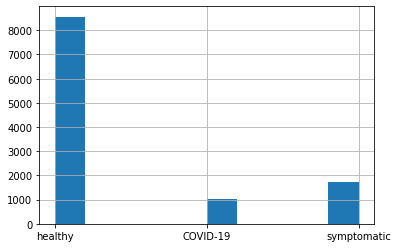

In [ ]:
df["status"].hist()

In [ ]:
signal = read_audio("/content/drive/MyDrive/wavFiles16000/00039425-7f3a-42aa-ac13-834aaa2b6b92.wav").squeeze()

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


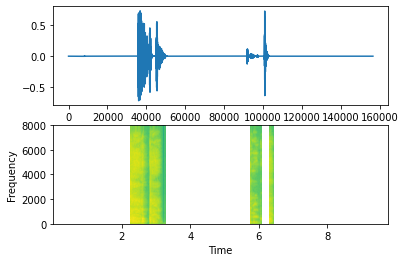

In [ ]:
# Plots
plt.subplot(211)
plt.plot(signal)
plt.xlabel('Time')

plt.subplot(212)
plt.specgram(signal,Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

Audio(signal, rate=16000)

In [ ]:
import torch  # noqa: F401
import torch.nn as nn
import speechbrain as sb
from speechbrain.nnet.pooling import StatisticsPooling
from speechbrain.nnet.CNN import Conv1d
from speechbrain.nnet.linear import Linear
from speechbrain.nnet.normalization import BatchNorm1d


class Xvector(torch.nn.Module):
    """This model extracts X-vectors for speaker recognition
    Arguments
    ---------
    activation : torch class
        A class for constructing the activation layers.
    tdnn_blocks : int
        Number of time-delay neural (TDNN) layers.
    tdnn_channels : list of ints
        Output channels for TDNN layer.
    tdnn_kernel_sizes : list of ints
        List of kernel sizes for each TDNN layer.
    tdnn_dilations : list of ints
        List of dilations for kernels in each TDNN layer.
    lin_neurons : int
        Number of neurons in linear layers.
    Example
    -------
    >>> compute_xvect = Xvector()
    >>> input_feats = torch.rand([5, 10, 40])
    >>> outputs = compute_xvect(input_feats)
    >>> outputs.shape
    torch.Size([5, 1, 512])
    """

    def __init__(self, device="cpu", activation=torch.nn.LeakyReLU, tdnn_blocks=5,
        tdnn_channels=[512, 512, 512, 512, 1500],
        tdnn_kernel_sizes=[5, 3, 3, 1, 1],
        tdnn_dilations=[1, 2, 3, 1, 1], lin_neurons=512, in_channels=40,):

        super().__init__()
        self.blocks = nn.ModuleList()

        # TDNN has convolutional layers with the given dilation factors
        # and kernel sizes. We here loop over all the convolutional layers
        # that we wanna add. Note that batch normalization is used after
        # the activations function in this case. This improves the
        # speaker-id performance a bit.
        for block_index in range(tdnn_blocks):
            out_channels = tdnn_channels[block_index]
            self.blocks.extend([Conv1d(in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=tdnn_kernel_sizes[block_index],
                        dilation=tdnn_dilations[block_index],),
                    activation(), BatchNorm1d(input_size=out_channels),])
            in_channels = tdnn_channels[block_index]

        # Statistical pooling. It converts a tensor of variable length
        # into a fixed-length tensor. The statistical pooling returns the
        # mean and the standard deviation.
        self.blocks.append(StatisticsPooling())

        # Final linear transformation.
        self.blocks.append(
            Linear(
                input_size=out_channels * 2,  # mean + std,
                n_neurons=lin_neurons,
                bias=True,
                combine_dims=False,
            )
        )

    def forward(self, x, lens=None):
        """Returns the x-vectors.
        Arguments
        ---------
        x : torch.Tensor
        """

        for layer in self.blocks:
            try:
                x = layer(x, lengths=lens)
            except TypeError:
                x = layer(x)
        return x


class Classifier(sb.nnet.containers.Sequential):
    """This class implements the last MLP on the top of xvector features.
    Arguments
    ---------
    input_shape : tuple
        Expected shape of an example input.
    activation : torch class
        A class for constructing the activation layers.
    lin_blocks : int
        Number of linear layers.
    lin_neurons : int
        Number of neurons in linear layers.
    out_neurons : int
        Number of output neurons.
    Example
    -------
    >>> input_feats = torch.rand([5, 10, 40])
    >>> compute_xvect = Xvector()
    >>> xvects = compute_xvect(input_feats)
    >>> classify = Classifier(input_shape=xvects.shape)
    >>> output = classify(xvects)
    >>> output.shape
    torch.Size([5, 1, 1211])
    """

    def __init__(
        self,
        input_shape,
        activation=torch.nn.LeakyReLU,
        lin_blocks=1,
        lin_neurons=512,
        out_neurons=1211,
    ):
        super().__init__(input_shape=input_shape)

        self.append(activation(), layer_name="act")
        self.append(sb.nnet.normalization.BatchNorm1d, layer_name="norm")

        if lin_blocks > 0:
            self.append(sb.nnet.containers.Sequential, layer_name="DNN")

        # Adding fully-connected layers
        for block_index in range(lin_blocks):
            block_name = f"block_{block_index}"
            self.DNN.append(sb.nnet.containers.Sequential, layer_name=block_name)
            self.DNN[block_name].append(sb.nnet.linear.Linear, n_neurons=lin_neurons, bias=True,layer_name="linear",)
            self.DNN[block_name].append(activation(), layer_name="act")
            self.DNN[block_name].append(sb.nnet.normalization.BatchNorm1d, layer_name="norm")

        # Final Softmax classifier
        self.append(sb.nnet.linear.Linear, n_neurons=out_neurons, layer_name="out")
        self.append(sb.nnet.activations.Softmax(apply_log=True), layer_name="softmax")

In [ ]:
import torch
from speechbrain.processing.speech_augmentation import AddNoise
noisifier = AddNoise('/content/drive/MyDrive/wavFiles16000/00039425-7f3a-42aa-ac13-834aaa2b6b92.wav', snr_low=0, snr_high=5)
lengths = torch.ones(1)
noisy = noisifier(signal.unsqueeze(0), lengths)

# Plots
plt.subplot(211)
plt.plot(noisy.squeeze())
plt.xlabel('Time')

plt.subplot(212)
plt.specgram(noisy.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

Audio(noisy.squeeze(0), rate=16000)

UnicodeDecodeError: ignored